In [2]:
import os
import dask
import dask.array as da
from skimage.io import imread
import numpy as np

# Function to read the image and convert it to an array of values
def load_image(file_path):
    # Use skimage or other libraries to read images
    img = imread(file_path)
    # Standardized images (0-1 range)
    return img / 255.0

# Function to get the path to all images
def get_image_paths(root_dir):
    image_paths = []
    for foldername in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, foldername)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith('.jpg'):
                    image_paths.append(os.path.join(folder_path, filename))
    return image_paths

root_dir = "train"
image_paths = get_image_paths(root_dir)

# Use the Dask delay operation to read pictures
lazy_arrays = [dask.delayed(load_image)(path) for path in image_paths]

# Get the size of the picture (assuming all pictures are the same size)
sample_img = imread(image_paths[0])
height, width, channels = sample_img.shape

# Create a Dask array
arrays = [da.from_delayed(lazy, shape=(height, width, channels), dtype=np.float32) for lazy in lazy_arrays]
dask_array = da.stack(arrays, axis=0)

# Calculate mean and std
mean = dask_array.mean(axis=(0, 1, 2)).compute()
std = dask_array.std(axis=(0, 1, 2)).compute()

print(f"Mean: {mean}, Std: {std}")



Mean: [0.47559854 0.50007176 0.42626825], Std: [0.2166402  0.19574274 0.23227517]


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Data set path
data_dir = "train"

# Converter: Only PIL images are converted to Tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()
])

# Create an ImageFolder data set
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# Initializes the accumulator
mean = 0.
std = 0.
nb_samples = 0.

# Traverse the DataLoader
for data, _ in dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

# Finally, mean and std are calculated
mean /= nb_samples
std /= nb_samples

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.4756, 0.5001, 0.4263])
Std: tensor([0.1849, 0.1594, 0.2027])


In [ ]:
pip install torch torchvision --user


In [ ]:
pip install --upgrade typing_extensions


Workers: 1, Time: 1321.2989768981934 seconds, Mean: [0.47559854 0.50007176 0.42626825], Std: [0.2166402  0.19574274 0.23227517]
Workers: 2, Time: 839.9947700500488 seconds, Mean: [0.47559854 0.50007176 0.42626825], Std: [0.2166402  0.19574274 0.23227517]
Workers: 4, Time: 535.9138307571411 seconds, Mean: [0.47559854 0.50007176 0.42626825], Std: [0.2166402  0.19574274 0.23227517]
Workers: 8, Time: 459.8774890899658 seconds, Mean: [0.47559854 0.50007176 0.42626825], Std: [0.2166402  0.19574274 0.23227517]


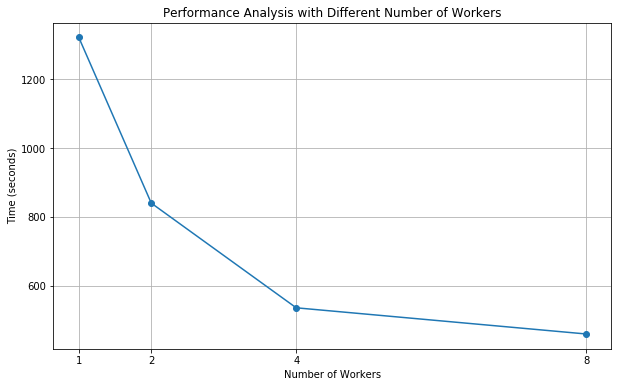

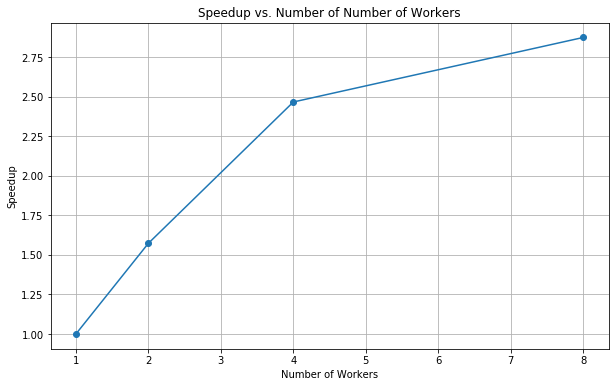

In [4]:
import os
import time
import dask
import dask.array as da
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Function to read the image and convert it to an array of values
def load_image(file_path):
    img = imread(file_path) # Use skimage or other libraries to read images
    return img / 255.0 # Standardized images (0-1 range)

# Function to get the path to all images
def get_image_paths(root_dir):
    image_paths = []
    if not os.path.exists(root_dir):
        print(f"Directory not found: {root_dir}")
        return image_paths

    for foldername in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, foldername)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith('.jpg'):
                    image_paths.append(os.path.join(folder_path, filename))
        else:
            print(f"Not a directory: {folder_path}")

    if not image_paths:
        print(f"No .jpg files found in {root_dir}")

    return image_paths

# Function to Calculate mean and std
def compute_mean_std(image_arrays):
    stack = da.stack(image_arrays)
    mean = stack.mean(axis=(0, 1, 2))
    std = stack.std(axis=(0, 1, 2))
    return mean, std


root_dir = "train"
image_paths = get_image_paths(root_dir)
sample_img = imread(image_paths[0])
height, width, channels = sample_img.shape # Get the size of the picture (assuming all pictures are the same size)

# test different numbers of workers
worker_settings = [1, 2, 4, 8]
times = []

for workers in worker_settings:
    dask.config.set(scheduler='processes', num_workers=workers)
    lazy_arrays = [dask.delayed(load_image)(path) for path in image_paths] # Use the Dask delay operation to read pictures
    arrays = [da.from_delayed(lazy, shape=(height, width, channels), dtype=np.float32) for lazy in lazy_arrays]
    dask_array = da.stack(arrays, axis=0)

    start_time = time.time()
    # Calculate mean and std
    mean = dask_array.mean(axis=(0, 1, 2)).compute()
    std = dask_array.std(axis=(0, 1, 2)).compute()
    end_time = time.time()
    time_elapsed = end_time - start_time
    times.append(time_elapsed)

    print(f"Workers: {workers}, Time: {end_time - start_time} seconds, Mean: {mean}, Std: {std}")
    

plt.figure(figsize=(10, 6))
plt.plot(worker_settings, times, marker='o')
plt.title('Performance Analysis with Different Number of Workers')
plt.xlabel('Number of Workers')
plt.ylabel('Time (seconds)')
plt.xticks(worker_settings)
plt.grid(True)
plt.savefig('Dask speed with Different Number of Workers.png')
plt.show()

speedup = [times[0] / t for t in times]


plt.figure(figsize=(10, 6))
plt.plot(worker_settings, speedup, marker='o')
plt.xlabel('Number of Workers')
plt.ylabel('Speedup')
plt.title('Speedup vs. Number of Workers')
plt.grid(True)
plt.savefig('Dask speed-up with Different Number of Workers.png')
plt.show()


Workers: 1, Time: 378.34706926345825 seconds, Mean: tensor([0.4756, 0.5001, 0.4263]), Std: tensor([0.2166, 0.1957, 0.2323])
Workers: 2, Time: 207.83265042304993 seconds, Mean: tensor([0.4756, 0.5001, 0.4263]), Std: tensor([0.2166, 0.1957, 0.2323])
Workers: 4, Time: 122.31705331802368 seconds, Mean: tensor([0.4756, 0.5001, 0.4263]), Std: tensor([0.2166, 0.1957, 0.2323])
Workers: 8, Time: 83.73807144165039 seconds, Mean: tensor([0.4756, 0.5001, 0.4263]), Std: tensor([0.2166, 0.1957, 0.2323])


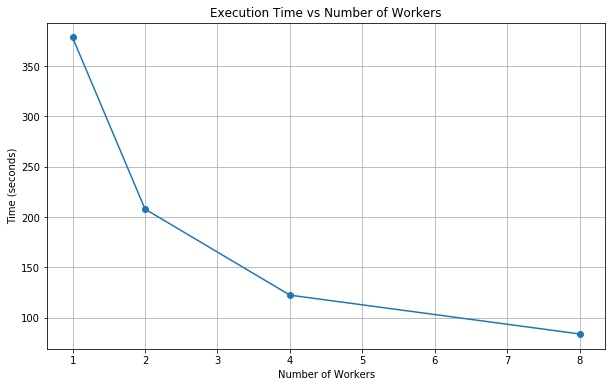

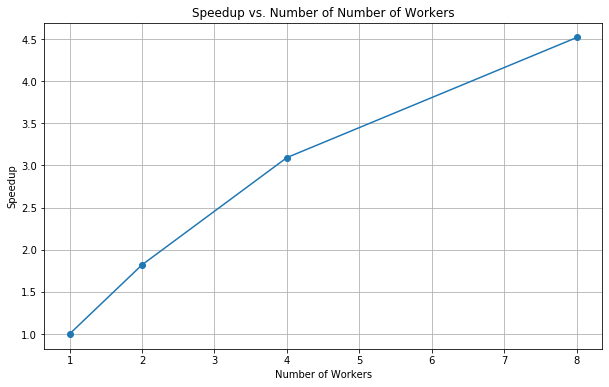

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

# Function to calculate mean and standard deviation
def calculate_mean_std(data_loader):
#     mean = 0.
#     std = 0.
#     nb_samples = 0.
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in data_loader:

        
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels
        
    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

#     mean /= nb_samples
#     std /= nb_samples

    return mean, std

# Dataset paths and converters
data_dir = "train"
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Test different number of workers
worker_counts = [1, 2, 4, 8]
times = []

for num_workers in worker_counts:
    # Create a dataset
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=num_workers)

    # Record time and calculate mean and standard deviation
    start_time = time.time()
    mean, std = calculate_mean_std(data_loader)
    end_time = time.time()

    # Record the time spent
    times.append(end_time - start_time)

    print(f"Workers: {num_workers}, Time: {end_time - start_time} seconds, Mean: {mean}, Std: {std}")


plt.figure(figsize=(10, 6))
plt.plot(worker_counts, times, marker='o')
plt.title("Execution Time vs Number of Workers")
plt.xlabel("Number of Workers")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.savefig('Pytorch speed with Different Number of Workers.png')
plt.show()

speedup = [times[0] / t for t in times]


plt.figure(figsize=(10, 6))
plt.plot(worker_counts, speedup, marker='o')
plt.xlabel('Number of Workers')
plt.ylabel('Speedup')
plt.title('Speedup vs. Number of Workers')
plt.grid(True)
plt.savefig('Pytorch speed-up with Different Number of Workers.png')
plt.show()
